# Gaussian Process for Machine Learning 
## Gaussian prior and posterior

- Implementation of "Seeger, M. (2004). Gaussian processes for machine learning. International journal of neural systems, 14(02), 69-106."
- Equations and approaches are cited from "Bishop, C. M. (2006). Pattern recognition and machine learning. springer."
- Using **GPyTorch** module to test sample function with different kernels: Gardner, Jacob R., Geoff Pleiss, David Bindel, Kilian Q. Weinberger, and Andrew Gordon Wilson. ” GPyTorch: Blackbox Matrix-Matrix Gaussian Process Inference with GPU Acceleration.” In NeurIPS (2018). 

To apply Gaussian process models to the problem of regression, we need to take account of the noise on the observed target values

$$y_n = u_n + \epsilon_n$$

where $u_n = u(x_n)$ and $\epsilon_n$ is random noise variable whose value is chosen independently for each observation $n$. Assume that we observe $N$ data points in the $N$-dimensional space.

Here we shall consider noise processes that have a Gaussian distribution, so that

$$p(y_n|u_n) = \mathcal{N}(y_n|u_n, \beta^{-1})$$

where $\beta$ is a hyperparameter representing the precision of the noise.

For indenpendent data points, the joint distribution of the target values $\mathbf{y} = (y_1, \dots, y_N)^T$ conditioned on $\mathbf{u} = (u_1, \dots, u_N)^T$ is given by an isotropic Gaussian of the form

$$p(\mathbf{y}|\mathbf{u}) = \mathcal{N}(\mathbf{y}|\mathbf{u}, \beta^{-1}\mathbf{I}_N)$$

where $\mathbf{I}_N$ denotes the N ×N unit matrix. From the definition of a Gaussian process, the marginal distribution $p(\mathbf{u})$ is given by a Gaussian whose mean is zero and whose covariance is defined by a Gram matrix $\mathbf(K)$ so that

$$p(\mathbf{u})=\mathcal{N}(\mathbf{u}|0,\mathbf{K})$$

The kernel function that determines $\mathbf{K}$ is typically chosen to express the property that, for points $x_n$ and $x_m$ that are similar, the corresponding values $u(x_n)$ and $u(x_m)$ will be more strongly correlated than for dissimilar points.

The marginal distribution of $\mathbf{y}$ is given by

$$p(\mathbf{y}) = \int{p(\mathbf{y}|\mathbf{u})p(\mathbf{u})d\mathbf{u}} = \mathcal{N}(\mathbf{y}|0,\mathbf{C})$$

where the covariance matrix $\mathbf{C}$ has elements

$$C(x_n,x_m)=k(x_n,x_m)+\beta^{-1}\delta_{nm}$$

The joint distribution over $y_1, \dots, y_{N+1}$ will be given by

$$p(\mathbf{y}_{N+1}) = \mathcal{N}(\mathbf{y}_{N+1}|0,\mathbf{C}_{N+1})$$

Because this joint distribution is Gaussian, we can apply the conditional Gaussian distribution.

$$\mathbf{C}_{N+1} = \left(   
                     \begin{matrix}
                     \mathbf{C}_{N} & \mathbf{k} \\
                     \mathbf{k} & c \\
                     \end{matrix}
                     \right)$$

where $c=k(x_{N+1}, x_{N+1})+\beta^{-1}$. We see that the conditional distribution $p(y_{N+1}|\mathbf{y})$ is a Gaussian distribution with mean and covariance given by 

$$\mu(x_{N+1}) = \mathbf{K}^T \mathbf{C}^{-1}_N \mathbf{y}$$
$$\sigma^2(x_{N+1}) = c-\mathbf{K}^T \mathbf{C}^{-1}_N \mathbf{y}$$

Instead of regressing against some known function, lets just see what happens when we predict based on the sampled prior. 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

Assumes we have a simple function of $x$ to generate $y$. 


$$y = \sin(2\pi x) + \epsilon $$
$$\epsilon \sim \mathcal{N}(0, 0.5)$$

In [2]:
torch.manual_seed(12345)

# Prior train data is in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 50)

# True function is sin(2*pi*x) with Gaussian noise
true_y = torch.sin(train_x * (2 * math.pi))
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.5

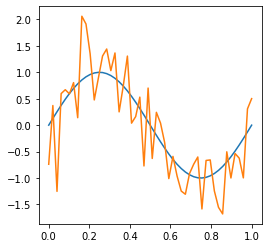

In [3]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.plot(train_x.numpy(), true_y.numpy())
    ax.plot(train_x.numpy(), train_y.numpy())

In [4]:
# We will use the simplest form of GP model, exact inference
class RBF_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RBF_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale=1.0))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Matern_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Matern_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

class Linear_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Linear_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Periodic_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Periodic_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)    

class Polynomial_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Polynomial_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=4))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)       

In [5]:
random_x = torch.randn(100)
random_y = torch.randn(100)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = RBF_GP_Model(random_x, random_y, likelihood)

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

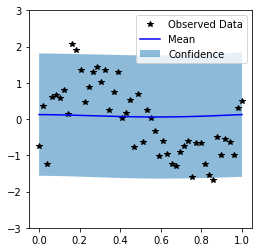

In [7]:
with torch.no_grad():
    # Initialize plot
    f0, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = RBF_GP_Model(train_x, train_y, likelihood)

In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

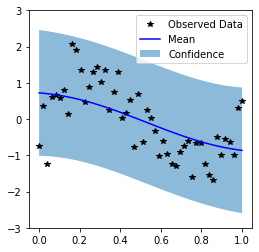

In [10]:
with torch.no_grad():
    # Initialize plot
    f1, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [11]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#    if i%10 ==9:
#        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#            i + 1, training_iter, loss.item(),
#            model.covar_module.base_kernel.lengthscale.item(),
#            model.likelihood.noise.item()
#        ))
    optimizer.step()
print("\n", loss.item())


 0.947857677936554


In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

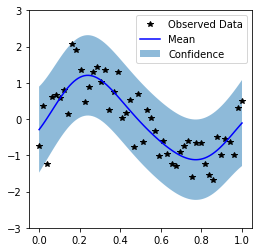

In [13]:
with torch.no_grad():
    # Initialize plot
    f2, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [14]:
#f0.savefig('result/prior-RBF_GP_Model.png')
#f1.savefig('result/posterior-RBF_GP_Model.png')
#f2.savefig('result/posterior(trained)-RBF_GP_Model.png')

## Results
#### RBF kernel 
\begin{equation*}
   k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
   (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-1} (\mathbf{x_1} - \mathbf{x_2}) \right)
\end{equation*}

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-RBF_GP_Model.png) | ![img](result/posterior-RBF_GP_Model.png) | ![img](result/posterior(trained)-RBF_GP_Model.png) |


#### Matern kernel
\begin{equation*}
   k_{\text{Matern}}(\mathbf{x_1}, \mathbf{x_2}) = \frac{2^{1 - \nu}}{\Gamma(\nu)}
   \left( \sqrt{2 \nu} d \right) K_\nu \left( \sqrt{2 \nu} d \right)
\end{equation*}

Where $d = (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-1} (\mathbf{x_1} - \mathbf{x_2})$, $\nu$ is a smoothness parameter and $K_\nu$ is a modified Bessel function.


$$\nu=0.5$$

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Matern_GP_Model-0.5.png) | ![img](result/posterior-Matern_GP_Model-0.5.png) | ![img](result/posterior(trained)-Matern_GP_Model-0.5.png) |

$$\nu=1.5$$

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Matern_GP_Model-1.5.png) | ![img](result/posterior-Matern_GP_Model-1.5.png) | ![img](result/posterior(trained)-Matern_GP_Model-1.5.png) |

$$\nu=2.5$$

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Matern_GP_Model-2.5.png) | ![img](result/posterior-Matern_GP_Model-2.5.png) | ![img](result/posterior(trained)-Matern_GP_Model-2.5.png) |


#### Linear kernel
\begin{equation*}
    k_\text{Linear}(\mathbf{x_1}, \mathbf{x_2}) = v\mathbf{x_1}^\top
    \mathbf{x_2}
\end{equation*}

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Linear_GP_Model.png) | ![img](result/posterior-Linear_GP_Model.png) | ![img](result/posterior(trained)-Linear_GP_Model.png) |

#### Periodic kernel
\begin{equation*}
   k_{\text{Periodic}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left(
     \frac{2 \sin^2 \left( \pi \Vert \mathbf{x_1} - \mathbf{x_2} \Vert_1 / p \right) }
     { \ell^2 } \right)
\end{equation*}

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Periodic_GP_Model.png) | ![img](result/posterior-Periodic_GP_Model.png) | ![img](result/posterior(trained)-Periodic_GP_Model.png) |

#### Polynomial kernel
\begin{equation*}
    k_\text{Poly}(\mathbf{x_1}, \mathbf{x_2}) = (\mathbf{x_1}^\top
    \mathbf{x_2} + c)^{d}.
\end{equation*}

$$\text{Quadratic case: } d=4$$

| Prior | Posterior | Posterior (Trained) |
|:------:|:------:|:------:|
| ![img](result/prior-Polynomial_GP_Model.png) | ![img](result/posterior-Polynomial_GP_Model.png) | ![img](result/posterior(trained)-Polynomial_GP_Model.png) |


| Kernel | Marginal Log Likelihood |
|:------:|:------:|
| RBF | 0.94785737 |
| Matern (0.5) | 0.99038773 |
| Matern (1.5) | 0.96494627 |
| Matern (2.5) | 0.95786011 |
| Linear | 1.22133493 |
| Periodic | 0.95173829 |
| Polynomial (quadratic) | 1.19192600 |

### references
- Bishop's Pattern Recognition and Machine Learning: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf
- Basic code: https://gpytorch.readthedocs.io
- Gaussian Distribution: http://norman3.github.io/prml/docs/chapter02/0